<a href="https://colab.research.google.com/github/masonnystrom/DS-Unit-2-Linear-Models/blob/master/module4-logistic-regression/LS_DS_214_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [0]:
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year

In [0]:
train = df[df['Year'] <=2016]
val = df[df['Year'] == 2017]
test = df[df['Year'] >= 2018]

In [17]:
print(train.shape, val.shape)
train.head()

(298, 61) (85, 61)


,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great,year,Year
0,California,2016-01-18,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,2016
1,California,2016-01-24,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,2016
2,Carnitas,2016-01-24,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,2016
3,Asada,2016-01-24,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,2016,2016
4,California,2016-01-27,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,2016,2016


In [19]:
train['Great'].value_counts()

False    176
True     122
Name: Great, dtype: int64

In [20]:
# baseline for classification
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [37]:
#Accuracy of baseline
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

0.5906040268456376

In [38]:
# Need Y val
y_val = val[target]
y_pred = [majority_class] *len(y_val)
accuracy_score(y_val, y_pred)

0.5529411764705883

In [0]:
# instantiate this class
linear_reg = LinearRegression()

In [29]:
# examine our categoricals
train.describe()

,Yelp,Google,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Queso,year,Year
count,71.000000,71.000000,292.000000,297.000000,0.0,0.0,175.000000,174.000000,174.000000,298.000000,283.000000,288.000000,297.000000,292.000000,296.000000,278.000000,296.000000,296.000000,0.0,298.000000,298.000000
mean,3.897183,4.142254,6.896781,3.445286,NaN,NaN,19.829886,22.042241,0.770920,3.472315,3.706360,3.551215,3.519024,3.528870,3.395946,3.324640,3.540203,3.955068,NaN,2015.979866,2015.979866
std,0.478680,0.371738,1.211412,0.852150,NaN,NaN,2.081275,1.685043,0.137833,0.797606,0.991897,0.869483,0.850348,1.040457,1.089044,0.971226,0.922426,1.167341,NaN,0.295187,0.295187
min,2.500000,2.900000,2.990000,0.500000,NaN,NaN,15.000000,17.000000,0.400000,1.400000,1.000000,1.000000,1.000000,0.500000,1.000000,0.000000,1.000000,0.000000,NaN,2011.000000,2011.000000
25%,3.500000,4.000000,6.250000,3.000000,NaN,NaN,18.500000,21.000000,0.662500,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,2.500000,3.000000,3.500000,NaN,2016.000000,2016.000000
50%,4.000000,4.200000,6.850000,3.500000,NaN,NaN,19.500000,22.000000,0.750000,3.500000,4.000000,3.500000,3.500000,4.000000,3.500000,3.500000,3.750000,4.000000,NaN,2016.000000,2016.000000
75%,4.000000,4.400000,7.500000,4.000000,NaN,NaN,21.000000,23.000000,0.870000,4.000000,4.500000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,5.000000,NaN,2016.000000,2016.000000
max,4.500000,4.900000,11.950000,5.000000,NaN,NaN,26.000000,27.000000,1.240000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,NaN,2016.000000,2016.000000


In [0]:
# linear regression
from sklearn.linear_model import LinearRegression

In [28]:
train.columns

Index(['Burrito', 'Date', 'Yelp', 'Google', 'Chips', 'Cost', 'Hunger',
       'Mass (g)', 'Density (g/mL)', 'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini',
       'Great', 'year', 'Year'],
      dtype='object')

In [0]:
# instantiate the class
linear_reg = LinearRegression()

# Arange X features matrix
features = ['Cost', 'Google', 'Uniformity']
X_train = train[features]
X_val = val[features]
# Y /dependent variable 
target = 'Great'
y_train = train[target]


In [0]:
#Impute missing values
from sklearn.impute import SimpleImputer
imputer = SimpleImputer()
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)

In [33]:
# fit the model
linear_reg.fit(X_train_imputed, y_train)

#apply the model

linear_reg.predict(X_val_imputed)

array([ 0.64085809,  0.57775591,  0.62129799,  0.65653508,  0.20824478,
        0.37694656,  0.49805227,  0.23232531, -0.08318562,  0.38835079,
        0.41990188,  0.28097918,  0.35371358,  0.34353076,  0.50128623,
        0.11030014,  0.1785785 ,  0.43567743,  0.57765735,  0.57765735,
        0.49877961,  0.74170831,  0.30716356,  0.70631905,  0.47582919,
        0.55470692,  0.42742172,  0.33625732,  0.47582919,  0.65176825,
        0.50998671,  0.68199212,  0.50183683,  0.35985691,  0.38333756,
        0.41488865,  0.34928124,  0.37876785,  0.64703758,  0.56674719,
        0.55898847,  0.34142691,  0.1857753 ,  0.42240849,  0.38353468,
        0.38353468,  0.49012967,  0.52515665,  0.73654292,  0.19668546,
        0.35371358,  0.44713819,  0.65580774,  0.57693   ,  0.42604521,
        0.43562815,  0.57038391,  0.5441836 ,  0.09194792,  0.40745885,
        0.31589169,  0.57484513,  0.51146904,  0.43259131,  0.38466479,
        0.54242025,  0.57289052,  0.73541281,  0.37375463,  0.67

In [34]:
# get coefficients
pd.Series(linear_reg.coef_, features)

Cost          0.072734
Google        0.224434
Uniformity    0.157755
dtype: float64

In [40]:
# import Logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(solver='lbfgs')
log_reg.fit(X_train_imputed, y_train)
print('Validation Accuracy', log_reg.score(X_val_imputed, y_val))

Validation Accuracy 0.5411764705882353


In [42]:
log_reg.predict(X_val_imputed)

array([ True,  True,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True, False,  True, False,  True, False,  True, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
       False, False,  True,  True, False, False, False,  True,  True,
       False, False,  True,  True, False, False, False,  True,  True,
       False, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False,  True, False, False,  True,  True, False,
       False,  True,  True,  True])

In [0]:
# validaiton accuracy

In [47]:
train.describe(exclude='number')

,Burrito,Date,Chips,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
count,298,298,22,27,5,168,143,139,149,119,85,43,20,20,5,33,32,11,7,7,1,7,37,6,15,17,4,7,1,4,4,1,4,3,3,2,13,2,1,298
unique,5,110,2,1,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2,1,2,2,2,2,2,2,2,1,1,1,1,1,1,1,1,1,2,1,2
top,California,2016-08-30 00:00:00,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,x,False
freq,118,29,19,27,3,130,115,101,121,97,63,29,19,17,3,24,24,9,5,4,1,5,33,5,9,9,3,5,1,4,4,1,4,3,3,2,13,1,1,176
first,NaN,2011-05-16 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,2016-12-15 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
features = ['Google', 'Cost', 'Hunger', 'Guac', 'Fries', 'Sauce', 'Rice', 'Pico', 'Cheese', 'Unreliable']
target = 'Great'

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]



In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
# Instantiate encoder from one hot encoder class
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

In [0]:
# impute the data / replace nulls 
imputer = SimpleImputer(strategy='mean')
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)


In [81]:
# Scaled the variables
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.fit_transform(X_val_imputed)

X_train_scaled[:5]

array([[ 3.20514492e-01, -3.39805235e-01, -5.24306577e-01,
         1.39660125e+00, -1.06952555e+00, -3.82300727e-01,
         1.43950163e+00, -1.22645900e+00, -2.82329851e-01,
         3.76513548e-01, -3.52885678e-01, -1.16642369e-01,
         3.52885678e-01, -2.95958174e-01, -1.76470588e-01,
         1.26146912e+00, -1.04111291e+00, -3.22030594e-01,
         1.20946679e+00, -1.00000000e+00, -3.22030594e-01,
         3.15643781e-01, -3.15643781e-01],
       [-4.67482113e+00, -1.20857147e+00,  6.44233034e-02,
         1.39660125e+00, -1.06952555e+00, -3.82300727e-01,
         1.43950163e+00, -1.22645900e+00, -2.82329851e-01,
         3.76513548e-01, -3.52885678e-01, -1.16642369e-01,
         3.52885678e-01, -2.95958174e-01, -1.76470588e-01,
         1.26146912e+00, -1.04111291e+00, -3.22030594e-01,
         1.20946679e+00, -1.00000000e+00, -3.22030594e-01,
         3.15643781e-01, -3.15643781e-01],
       [-4.92972144e-15, -1.70978276e+00, -2.29049622e+00,
         1.39660125e+00, -1.0

In [82]:
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)


LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [83]:
y_pred = model.predict(X_val_scaled)
accuracy_score(y_val, y_pred)

0.5764705882352941

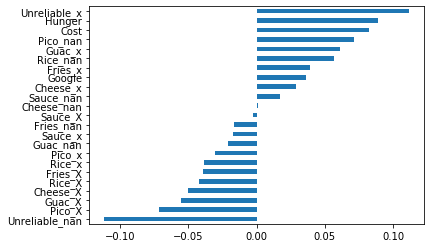

In [84]:
import matplotlib.pyplot as plt
%matplotlib inline

coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
coefficients.sort_values().plot.barh();

In [85]:
# test accuracy
X_test = test[features]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded)
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

y_pred = model.predict(X_test_scaled)
y_pred

array([ True, False,  True,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False])

In [0]:
submission = test[['Burrito']].copy()
submission['Great'] = y_pred

In [90]:
submission.to_csv('Titanic-submission-01.csv',index=False)
submission

,Burrito,Great
77,California,True
386,California,False
387,Other,True
388,California,True
389,Other,False
390,Asada,False
391,Carnitas,False
392,Carnitas,False
393,Carnitas,False
394,California,True
